<a href="https://colab.research.google.com/github/suryogumilar/Tensorflow_timeseries/blob/main/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Deep Neural Network with Time Series Data

Build from [previous](https://github.com/suryogumilar/Tensorflow_timeseries/blob/main/C4_W2_Lab_2_single_layer_NN.ipynb) we add more layer and implement technique to tune the model's learning rate to make the weights converge faster.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
# for timezone()
import pytz
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from IPython.display import clear_output
import random
import os

## functions

we'll define some utility functions that we'll repeatedly use

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


In [3]:
def plot_series_plotly(time, series, series_name=None, 
                       figure_title='', showlegend=False, 
                       start=0, end=None):
    """
    Visualizes time series data but using plotly for interactive graph

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      series_name (array of string) - contains correlative name of each series
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    fig = go.Figure()
    # Setup dimensions of the graph figure
    
    if type(series) is tuple:
      ii = 0
      for series_num in series:
        # Plot the time series data
        fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series_num[start:end], mode='lines',
                                 name=series_name[ii]))  
        ii = ii+1
    else:
      # Plot the time series data
      fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series[start:end], mode='lines'))

    fig.update_layout(title=figure_title, xaxis_title="Time", yaxis_title="Value",
                      autosize=False,
                      width=600,
                      height=600,
                      margin=dict(
                        l=50,
                        r=50,
                        b=100,
                        t=100,
                        pad=4
                        ), paper_bgcolor="LightSteelBlue"
                        , showlegend=showlegend
                      )
    fig.show()

In [4]:
def plot_candlesticks(df, figure_title='', showlegend=False):
  fig = go.Figure(data= [go.Candlestick(x=df['Date'],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close']
                             )])
  fig.update_layout(title=figure_title, xaxis_title="Time", yaxis_title="Value",
                    autosize=False,
                    width=600,
                    height=600,
                    margin=dict(
                        l=50,
                        r=50,
                        b=100,
                        t=100,
                        pad=4
                    ),
                    paper_bgcolor="LightSteelBlue", showlegend=showlegend
                  )
  fig.show()

In [5]:
def getStockData(history_span:int, the_ticker:str):
  """
  Getting stock data from Yahoo Finance API

  Args:
    history_span (int) how much backdate data to be collected
    the_ticker (string) ticker name on yahoo finance API
  Returns:
    Pandas dataframe (pd.DataFrame) containing stock data    
  """
  THE_URL = ('https://query1.finance.yahoo.com/v7/finance/'+
           'download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true')
  tdy = datetime.datetime.now(tz=pytz.timezone('Asia/Jakarta'))

  p2 = math.ceil(tdy.timestamp())
  p1 = math.floor((tdy - relativedelta(years=history_span)).timestamp())
  yf_url = THE_URL.format(ticker=the_ticker,period1=p1, period2=p2)
  df = pd.read_csv(yf_url)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  return df

creating windowed dataset

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

#### functions related to tensorflows

`set_seed()`

setting random seed is necessary for reproducible results so that we can compare various methods performance and when tweaking the hyperparameters.

from [How to set random seeds](https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy) article

In [7]:
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)

  try:
    tf.set_random_seed(seed)
  except AttributeError as ae:
    print('INFO: tf.set_random_seed is deprecated in tf version ', tf.__version__, ' ',ae )
  
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")


In [ ]:
stock_name = str(input("Stock tick:"))
hist_data = int(input("historical data (year):"))
clear_output(wait=True)

In [9]:
df = getStockData(hist_data, stock_name)

In [10]:
plot_series_plotly(df['Date'], (df['Open'], df['Close']),
                   series_name=['Open', 'Close'],
                   figure_title='price', showlegend=True)

In [11]:
plot_candlesticks(df,  figure_title='stocks')

## Split the Dataset

split the dataset as training and test

Please do note in mind that when splitting the data into training and test set always take care on the distribution of data. Does it represent data on each month equally? Does the data have seasonal feature in it? Does it actually creates bias instead?

In [12]:
split_ratio = 0.8
rows_of_dataframe = df.shape[0]

training_ds_rows = round(rows_of_dataframe * split_ratio)
test_ds_rows = round(rows_of_dataframe * (1- split_ratio))

df_training = df[:training_ds_rows]
df_test = df[training_ds_rows:]

print(df.shape)
print(df_training.shape)
print(df_test.shape)

(736, 7)
(589, 7)
(147, 7)


In [13]:
plot_series_plotly(df_training['Date'], df_training['Close'],
                   figure_title='training dataset')

In [14]:
plot_series_plotly(df_test['Date'], df_test['Close'],
                   figure_title='test dataset')

## Normalize
we normalize the training data first. Also we add denormalizer to return predicted data into its real values

In [15]:
normalizer_univar = tf.keras.layers.Normalization(axis=None)
denormalizer_univar = tf.keras.layers.Normalization(axis=None, invert=True)
training_set = tf.convert_to_tensor(df_training['Close'])
normalizer_univar.adapt(training_set)
training_set_normalized = normalizer_univar(training_set)

print('training set range:')
print('before normalized:')
print('min:',tf.reduce_min(training_set, axis=0).numpy())
print('max:', tf.reduce_max(training_set, axis=0).numpy())
print('after normalized:')
print('min:',tf.reduce_min(training_set_normalized, axis=0).numpy())
print('max:', tf.reduce_max(training_set_normalized, axis=0).numpy())

# train denormalizer layer
denormalizer_univar.adapt(training_set_normalized)
training_set_denormalized = normalizer_univar(training_set_normalized)
print('after denormalized:')
print('min:',tf.reduce_min(training_set_normalized, axis=0).numpy())
print('max:', tf.reduce_max(training_set_normalized, axis=0).numpy())


test_set = tf.convert_to_tensor(df_test['Close'])
test_set_normalized = normalizer_univar(test_set)
print()
print('test set range:')
print('min:',tf.reduce_min(test_set_normalized, axis=0).numpy())
print('max:', tf.reduce_max(test_set_normalized, axis=0).numpy())


training set range:
before normalized:
min: 2560.0
max: 4770.0
after normalized:
min: -1.8429056
max: 2.3357658
after denormalized:
min: -1.8429056
max: 2.3357658

test set range:
min: 0.12352806
max: 2.2979498


## Prepare features and labels

prepare window data for time series forecasting

In [16]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
windowed_training_ds = windowed_dataset(training_set_normalized, window_size, 
                           batch_size, shuffle_buffer_size)

# Print properties of a single batch
for windows in windowed_training_ds.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model


In [17]:
class TS_DNN_Model(tf.keras.Model):
  def __init__(self, window_size,
               normalizer_layer=None,
               denormalizer_layer=None,
               **kwargs):
    super(TS_DNN_Model, self).__init__(**kwargs)

    self.normalizer_1 = normalizer_layer
    self.denormalizer_1 = denormalizer_layer
    self.seq_1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(1)
    ])

  def normalize(self, x):
    return self.normalizer_1(x)
  
  def denormalize(self, x):
    return self.denormalizer_1(x)
    
  def call(self, x):
    x = self.seq_1(x)
    return x

In [18]:
# setting random seeds
set_seed(1)
model_baseline = TS_DNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)
model_baseline.build(input_shape = (1, window_size))
# Print the model summary
model_baseline.summary()

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1
Model: "ts_dnn__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 normalization_1 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential (Sequential)     (None, 1)                 331       
                                                                 
Total params: 337
Trainable params: 331
Non-trainable params: 6
_________________________________________________________________


## Train the model

we use the same settings as  before

In [19]:
# Set the training parameters
model_baseline.compile(loss="mse", 
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, 
                                                         momentum=0.9))

In [20]:
# Train the model
epochs = 100
history_baseline = model_baseline.fit(windowed_training_ds, epochs=epochs, verbose=0)


## Plot the model loss values

dict_keys(['loss'])


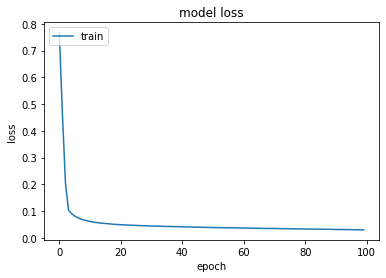

In [21]:
print(history_baseline.history.keys())
# summarize history for loss
plt.plot(history_baseline.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [22]:
plot_series_plotly(np.arange(0,epochs), 
                   history_baseline.history['loss'], figure_title='Loss value' )

last loss value would be around 0.030145.  As a comparison, using single layer in previous notebook (linear regression) we got around 0.028309

In [61]:
history_baseline.history['loss'][-1]

0.03014492429792881

## Model Prediction

In [23]:
# Initialize a list
forecast = []

dataset_to_forecast = df['Close'].iloc[training_ds_rows-window_size:]
print(dataset_to_forecast.shape)
ds_normalized = model_baseline.normalize(dataset_to_forecast)
print(ds_normalized.shape)

for time in range(ds_normalized.shape[0] - window_size):
  forecast.append(model_baseline.predict(
      np.expand_dims(ds_normalized[time:time + window_size], axis=0), verbose=0))
print(time,':',(time + window_size))  
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {test_set_normalized.shape}')

(167,)
(167,)
146 : 166
length of the forecast list: 147
shape of the validation set: (147,)


To visualize the results, you will need to convert the predictions to a form that the plot_series() utility function accepts. That involves converting the list to a numpy array and dropping the single dimensional axes

shape after converting to numpy array: (147, 1, 1)
shape after squeezing: (147,)


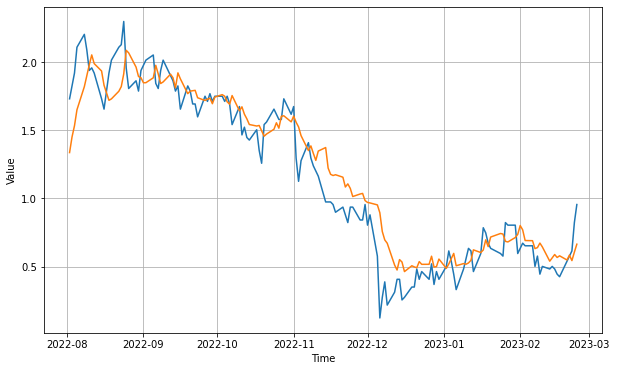

In [24]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set_normalized, results))

In [25]:

plot_series_plotly(df_test['Date'], (test_set_normalized, results),
                   series_name=['test_set','prediction'],
                   figure_title='dataset normalized',
                   showlegend=True)

## Count the metrics

In [26]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(test_set_normalized, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_set_normalized, results).numpy())

0.035348654
0.14507182


### no normalize data test

In [27]:
# Initialize a list
forecast = []

dataset_to_forecast = df['Close'].iloc[training_ds_rows-window_size:]

for time in range(dataset_to_forecast.shape[0] - window_size):
  forecast.append(model_baseline.predict(
      np.expand_dims(dataset_to_forecast[time:time + window_size], axis=0), verbose=0))
  
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {test_set.shape}')

length of the forecast list: 147
shape of the validation set: (147,)


shape after converting to numpy array: (147, 1, 1)
shape after squeezing: (147,)


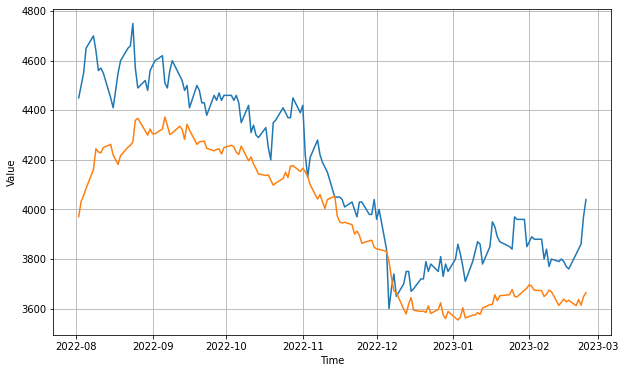

In [28]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set, results))
     

In [29]:
plot_series_plotly(df_test['Date'], (test_set, results),
                   series_name=['test_set','prediction'],
                   figure_title='dataset',
                   showlegend=True)

In [30]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(test_set, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_set, results).numpy())

51559.246
202.33589


## Tune the learning rate

we use callbacks to tune the learning rate. This will allow us to dynamically set the learning rate based on the epoch number during training. As shown below, we will pass a lambda function to declare the value of the learning rate. It will start at 1e-7 at epoch 0 and is scaled by 10**(epoch / 20) as the training goes on.

In [31]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

create the model

In [32]:
# setting random seeds
set_seed(1)
model_tune = TS_DNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)


INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1


Here we don't have to set the learning_rate argument of the optimizer here before compiling. We can just leave the default (i.e. `0.01` for [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#args)) and allow the learning rate scheduler to set it dynamically.

In [33]:
model_tune.build(input_shape = (1, window_size))
# Print the model summary
model_tune.summary()

# Set the training parameters
model_tune.compile(loss="mse", 
                       optimizer=tf.keras.optimizers.SGD(momentum=0.9))

Model: "ts_dnn__model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 normalization_1 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential_1 (Sequential)   (None, 1)                 331       
                                                                 
Total params: 337
Trainable params: 331
Non-trainable params: 6
_________________________________________________________________


pass in the lr_schedule callback in the callbacks parameter of the `fit()` method

In [34]:
# Train the model
history_tune = model_tune.fit(windowed_training_ds, epochs=epochs, 
                              callbacks=[lr_schedule],
                              verbose=0)

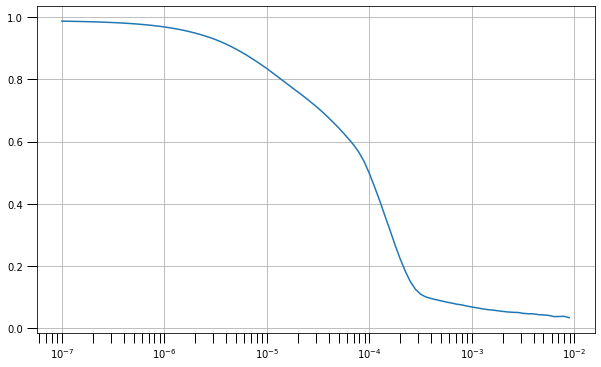

In [35]:
# Define the learning rate array
lrs = 1e-7 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_tune.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
#plt.axis([1e-8, 1e-3, 0, 300])

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will be shown in the next cells.

In [36]:
plot_series_plotly(np.arange(0,100), 
                   history_tune.history['loss'], figure_title='Loss value' )

In [37]:
history_tune.history["loss"][-1]

0.03299391269683838

In [62]:
history_baseline.history['loss'][-1]

0.03014492429792881

compare this loss value with previous last loss value (without learning rate scheduler = 0.030145) and (linear regression = 0.028309) 

## learning rate with initialize parameter

based on previous learning rate we initialize according the downward slope

In [38]:
# setting random seeds
set_seed(1)
model_tune_2 = TS_DNN_Model(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1


In [39]:
model_tune_2.build(input_shape = (1, window_size))
# Print the model summary
model_tune_2.summary()

Model: "ts_dnn__model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 normalization_1 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential_2 (Sequential)   (None, 1)                 331       
                                                                 
Total params: 337
Trainable params: 331
Non-trainable params: 6
_________________________________________________________________


In [40]:
10**(-4)

0.0001

In [41]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Set the training parameters
model_tune_2.compile(loss="mse", 
                       optimizer=optimizer)

In [42]:

# Train the model
history_tune_2 = model_tune_2.fit(windowed_training_ds, epochs=epochs, verbose=0)

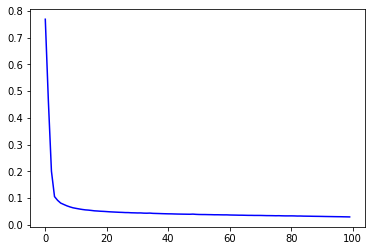

In [43]:
# Plot the loss
loss = history_tune_2.history['loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, 'b', label='Training Loss')
plt.show()

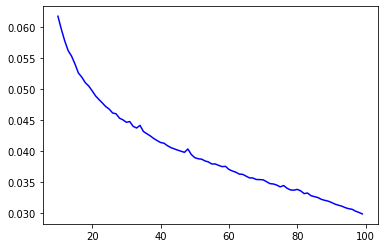

In [44]:
# Plot all but the first 10
loss = history_tune_2.history['loss']
epochs_range = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs_range, plot_loss, 'b', label='Training Loss')
plt.show()

In [45]:
plot_series_plotly(np.arange(0,100), history_tune_2.history['loss'], figure_title='Loss value' )

In [63]:
print('now to compare')
print(history_baseline.history["loss"][-1])
print(history_tune.history["loss"][-1])
print(history_tune_2.history["loss"][-1])


now to compare
0.03014492429792881
0.03299391269683838
0.02990170568227768


get the preictions again and overlay it on the validation set.

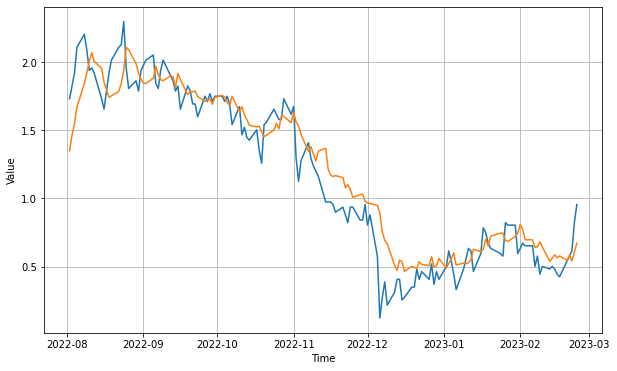

In [47]:
forecast = []

for time in range(ds_normalized.shape[0] - window_size):
  forecast.append(model_tune_2.predict(
      np.expand_dims(ds_normalized[time:time + window_size], axis=0), verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set_normalized, results))


In [48]:
plot_series_plotly(df_test['Date'], (test_set_normalized, results),
                   series_name=['test_set','prediction'],
                   figure_title='dataset normalized',
                   showlegend=True)

In [49]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(test_set_normalized, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_set_normalized, results).numpy())

0.0345492
0.14427623


without normalization

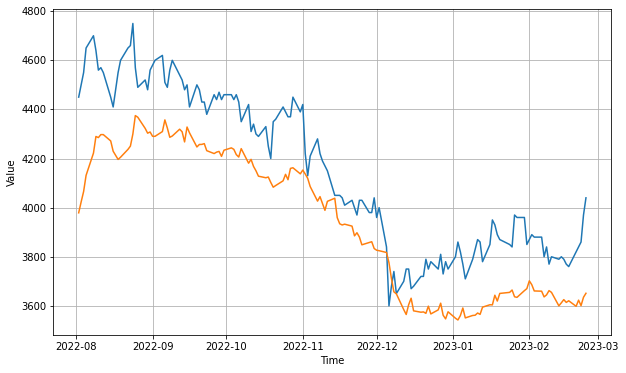

In [50]:
# Initialize a list
forecast = []

dataset_to_forecast = df['Close'].iloc[training_ds_rows-window_size:]

for time in range(dataset_to_forecast.shape[0] - window_size):
  forecast.append(model_tune_2.predict(
      np.expand_dims(dataset_to_forecast[time:time + window_size], axis=0), verbose=0))
  
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set, results))


In [51]:
plot_series_plotly(df_test['Date'], (test_set, results),
                   series_name=['test_set','prediction'],
                   figure_title='dataset',
                   showlegend=True)

In [52]:

# Compute the metrics
print(tf.keras.metrics.mean_squared_error(test_set, results).numpy())
print(tf.keras.metrics.mean_absolute_error(test_set, results).numpy())

53881.047
210.8438


## Use tf.function and add layer normalization inside networks sequence

Using deep NN we got about 13 to 14 seconds when training the data and around 11 seconds when predicting test set data. Now we use tf.fucntion to try to optimize running code

In [53]:
class TS_DNN_Model_tff(tf.keras.Model):
  def __init__(self, window_size,
               normalizer_layer=None,
               denormalizer_layer=None,
               **kwargs):
    super(TS_DNN_Model_tff, self).__init__(**kwargs)

    self.normalizer_1 = normalizer_layer
    self.denormalizer_1 = denormalizer_layer
    self.seq_1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(1)
    ])
  
  def normalize(self, x):
    return self.normalizer_1(x)
  
  def denormalize(self, x):
    return self.denormalizer_1(x)

  @tf.function  
  def call(self, x):
    x = self.seq_1(x)
    return x

In [54]:
# setting random seeds
set_seed(1)

model_tff = TS_DNN_Model_tff(window_size=window_size, 
                              normalizer_layer=normalizer_univar,
                              denormalizer_layer=denormalizer_univar)

model_tff.build(input_shape = (1, window_size))
# Print the model summary
model_tff.summary()

INFO: tf.set_random_seed is deprecated in tf version  2.11.0   module 'tensorflow' has no attribute 'set_random_seed'
Random seed set as 1
Model: "ts_dnn__model_tff"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 normalization_1 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 sequential_3 (Sequential)   (None, 1)                 331       
                                                                 
Total params: 337
Trainable params: 331
Non-trainable params: 6
_________________________________________________________________


In [55]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Set the training parameters
model_tff.compile(loss="mse", 
                       optimizer=optimizer)

In [56]:
# Train the model
history_tff = model_tff.fit(windowed_training_ds, epochs=100, verbose=0)

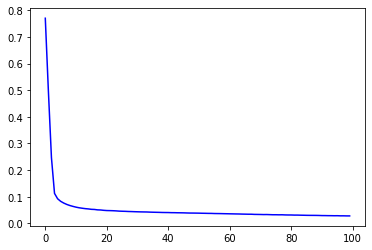

In [57]:
# Plot the loss
loss = history_tff.history['loss']
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, 'b', label='Training Loss')
plt.show()

In [58]:
plot_series_plotly(np.arange(0,100), history_tff.history['loss'], 
                   figure_title='Loss value' )
     


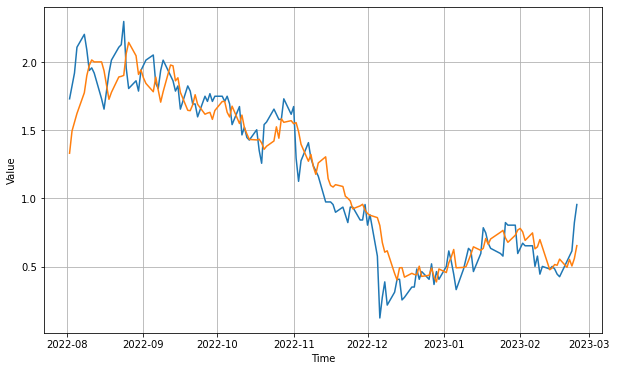

In [59]:
forecast = []

for time in range(ds_normalized.shape[0] - window_size):
  forecast.append(model_tff.predict(
      np.expand_dims(ds_normalized[time:time + window_size], axis=0), verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (test_set_normalized, results))

In [64]:

print('now to compare')
print(history_baseline.history["loss"][-1])
print(history_tune.history["loss"][-1])
print(history_tune_2.history["loss"][-1])
print(history_tff.history["loss"][-1])

now to compare
0.03014492429792881
0.03299391269683838
0.02990170568227768
0.02799481526017189


the code runtime has not change much but the loss value got quite better